This code runs Deep Learning on nutau and nue samples created by Dasha. 

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.  Can remove from environment.)

To run with multiple GPUs on CyberLAMP you must specify the "nodes" and "gpus" qualifiers in the same chunk.  For example:
- qsub -I -A cyberlamp -l qos=cl_higpu -l nodes=1:ppn=1:gpus=4:shared -l mem=24gb -l walltime=4:00:00

In [1]:
import os

# Set which GPU to use.  This probably needs to be done before any other CUDA vars get defined.
# Use the command "nvidia-smi" to get association of a particular GPU with a particular number.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle

In [3]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


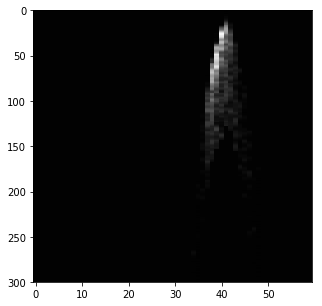

In [4]:
nu_size = 7737578
nu_data = np.memmap('/fastio2/dasha/double_pulse/nu_data.npy', mode = 'r', dtype ='float32', shape = (nu_size,300,60))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(nu_data[0], interpolation='nearest', aspect='auto', cmap= 'gray')

In [7]:
print(np.amax(nu_data))
print(np.amin(nu_data))

7.63065e-09
-4.75539e-10


In [5]:
nu_labels = np.memmap('/fastio2/dasha/double_pulse/nu_label.npy', mode = 'r', dtype ='float32', shape = (nu_size))
labels = []
for i in nu_labels:
    if i == 4:
        labels.append([0,0,1])
    elif i == 2:
        labels.append([0,1,0])
    else:
        labels.append([1,0,0])
labels = np.array(labels)
print(labels.shape)
print(labels[0:10])


(7737578, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [6]:
print(labels[6600000:6600010])

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [7]:
print(sum(labels))

[3867925 2960557  909096]


In [8]:
idx = np.arange(nu_size)
np.random.shuffle(idx)
print(idx[:10])

[4724180 7180687 3282754 4863643 2737586 2539956 3705152 7169900 3710465
 2584293]


In [9]:
train_idx = idx[:100000] 
test_idx = idx[100000:130000] 
valid_idx = idx[130000:160000]

In [10]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []

for i in train_idx:
    train_data.append(nu_data[i])
    train_labels.append(labels[i])
for i in test_idx:
    test_data.append(nu_data[i])
    test_labels.append(labels[i])
for i in valid_idx:
    valid_data.append(nu_data[i])
    valid_labels.append(labels[i])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
    

In [11]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(100000, 300, 60) (100000, 3)
(30000, 300, 60) (30000, 3)
(30000, 300, 60) (30000, 3)


In [12]:
print(sum(train_labels))
print(sum(test_labels))
print(sum(valid_labels))

[49937 38398 11665]
[15001 11489  3510]
[15052 11457  3491]


In [13]:
train_data = train_data.reshape((len(train_data),300,60,1))
train_data = train_data.astype('float32')/10**-8
mean = np.mean(train_data)
std = np.std(train_data)
print(mean,std)
train_data = train_data - mean
train_data = train_data/std

valid_data = valid_data.reshape((len(valid_data),300,60,1))
valid_data = valid_data.astype('float32')/10**-8
valid_data = valid_data - mean
valid_data = valid_data/std

test_data = test_data.reshape((len(test_data),300,60,1))
test_data = test_data.astype('float32')/10**-8
test_data = test_data - mean
test_data = test_data/std

0.0010935264 0.013415054


In [81]:
print(np.amax(train_data))
print(np.amin(train_data))

51.049015
-0.9255073


In [14]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [39]:
#for im in data_d[:100]:
#    print(im.shape)
#    fig = plt.figure(figsize=(12, 12))
#    ax = fig.add_subplot(111)
#    ax.imshow(im, interpolation='nearest', aspect='auto', cmap= 'gray')
    #ax.plot(im[14,:])
    #print(im[:,46])

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

W0823 18:55:17.106038 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 18:55:17.125954 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 18:55:17.132312 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 18:55:17.301606 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0823 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 58, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 29, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 27, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 5, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 3, 128)        147584    
__________

In [16]:
from keras import optimizers
import tensorflow as tf

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

sgd = optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#              options = run_opts)

W0823 18:55:20.968106 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 18:55:20.977681 140713723979520 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [17]:
history = model.fit(train_data,train_labels, epochs=30, validation_data=(valid_data,valid_labels), batch_size =128)

W0823 18:55:28.403977 140713723979520 deprecation.py:323] From /home/dup193/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 100000 samples, validate on 30000 samples
Epoch 1/30
100000/100000 [==============================] - 562s 6ms/step - loss: 0.9716 - acc: 0.5022 - val_loss: 0.9582 - val_acc: 0.5070
Epoch 2/30
100000/100000 [==============================] - 551s 6ms/step - loss: 0.9571 - acc: 0.5114 - val_loss: 0.9519 - val_acc: 0.5157
Epoch 3/30
100000/100000 [==============================] - 535s 5ms/step - loss: 0.9511 - acc: 0.5225 - val_loss: 0.9477 - val_acc: 0.5272
Epoch 4/30
100000/100000 [==============================] - 545s 5ms/step - loss: 0.9444 - acc: 0.5344 - val_loss: 0.9429 - val_acc: 0.5332
Epoch 5/30
100000/100000 [==============================] - 552s 6ms/step - loss: 0.9360 - acc: 0.5478 - val_loss: 0.9354 - val_acc: 0.5536
Epoch 6/30
100000/100000 [==============================] - 549s 5ms/step - loss: 0.9268 - acc: 0.5599 - val_loss: 0.9227 - val_acc: 0.5547
Epoch 7/30
100000/100000 [==============================] - 553s 6ms/step - loss: 0.9177 - acc: 0.5699 - val_

In [18]:
import json
history_dict = history.history # Get the dictionary containing each metric and the loss for each epoch
json.dump(history_dict, open('/data/dfc13/DoublePulse/Models/DP_model_New_1.json', 'w')) # Save it under the form of a json file
#
model.save('/data/dfc13/DoublePulse/Models/DP_model_New_1.h5') # Save the model
#
ResultsFile = open('/data/dfc13/DoublePulse/Models/DP_model_New_1.txt','w') # File for saving the results of the fit.
#
# 8: multiple conv2d layers a la textbook (32 (3,3) then 64, 128, 128, dropout 0.3, dense 256(relu), 64(relu), 2(softmax)
# 8b: same as 8 but with 50 trials
# 8b[not c didn't update the line above]: same as 8b but with dropout 0.5.
# 8c: changed SGC "lr" from 0.01->0.001.  This smoothed things out a lot.  Sort of.  But had 0% accuracy for nutaus.
# 8d: changed SGC "lr" from 0.001->0.005.
# 8e: decreased size of training set to 24k, increased size of validation set to 4k (24k:28k) and increased test set (28k:)
# 8f: changed SGC "lr" from 0.005->0.01.  200 epochs. 97%/37%.
# 8g: lr=0.02, 50 epochs: 98%/29%.

# 9a: changed dense 256 -> 512.  50 epochs. 100%/22%
# 9b: same as above, 200 epochs. 97%/39%.
# 9c: same as above, lr = 0.01.  200 epochs. 97%/36%.
# 9d: same as above, 500 epochs batch_size = 64. 96%/40%.
# 10a: Testing selection of particular GPU.  20 epochs, batch_size = 128.
# 10b: Testing parallelization.  50 epochs, batch_size = 128, one GPU. 98%/22%.
# 10g: 
# New_1: New data (160000 ims)

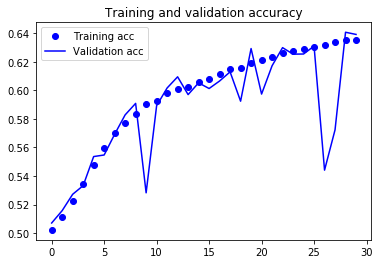

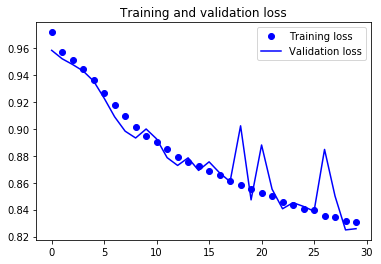

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
result = model.evaluate(test_data,test_labels)
print(result)

30000/30000 [==============================] - 35s 1ms/step
[0.8315296581586202, 0.6374666666666666]


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
test_pred = model.predict(test_data)

In [23]:
print(test_pred[0:100])
print(test_pred.argmax(axis=1)[0:100])

[[6.59401953e-01 1.99468121e-01 1.41129896e-01]
 [7.97021389e-01 9.72451121e-02 1.05733477e-01]
 [6.65813386e-01 2.17168331e-01 1.17018260e-01]
 [5.85838914e-01 2.94897556e-01 1.19263545e-01]
 [3.57772082e-01 4.95628238e-01 1.46599740e-01]
 [4.90046948e-01 3.88970405e-01 1.20982684e-01]
 [1.26650244e-01 8.30923498e-01 4.24262471e-02]
 [7.51939535e-01 1.25163049e-01 1.22897446e-01]
 [6.08531296e-01 2.73686409e-01 1.17782339e-01]
 [5.93282223e-01 2.84480572e-01 1.22237213e-01]
 [5.80975056e-01 2.99479097e-01 1.19545862e-01]
 [4.09056097e-01 4.45143193e-01 1.45800680e-01]
 [5.80975056e-01 2.99479097e-01 1.19545862e-01]
 [5.02609849e-01 3.39346319e-01 1.58043772e-01]
 [5.80975056e-01 2.99479097e-01 1.19545862e-01]
 [5.20149231e-01 3.59521508e-01 1.20329328e-01]
 [6.26159549e-01 2.50833482e-01 1.23006970e-01]
 [6.80711687e-01 1.98657736e-01 1.20630585e-01]
 [6.21437490e-01 2.60685503e-01 1.17876992e-01]
 [7.76586473e-01 1.09801166e-01 1.13612331e-01]
 [4.76133734e-01 4.03257817e-01 1.206083

In [24]:
matrix = confusion_matrix(test_labels.argmax(axis=1), test_pred.argmax(axis=1))
report = classification_report(test_labels.argmax(axis=1), test_pred.argmax(axis=1))

In [25]:
#print("True Positive",tp)
#print("True Negative",tn)
#print("False Positive",fp)
#print("False Negative",fn)
print(matrix)
print(report)

#ResultsFile.write(repr(matrix))
#ResultsFile.write('\n')
#ResultsFile.write(report)
#ResultsFile.close()

[[14073   926     2]
 [ 6434  5035    20]
 [ 3001   493    16]]
              precision    recall  f1-score   support

           0       0.60      0.94      0.73     15001
           1       0.78      0.44      0.56     11489
           2       0.42      0.00      0.01      3510

    accuracy                           0.64     30000
   macro avg       0.60      0.46      0.43     30000
weighted avg       0.65      0.64      0.58     30000

